Libraries/module Imports

In [1]:
#   Custom imports for testing
from classification.cnn import CNNClassifier, GraphDataset, DataLoader
from utils.import_data import import_all_data, import_panda_csv
from utils.constants import BAND_NAMES
from utils.plot_fig import (
    plot_avg_roc_curve,
    plot_accuracies,
    plot_losses
)

%load_ext autoreload
%autoreload 2

In [2]:
#   Python imports
import numpy as np

In [3]:
#   Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="whitegrid")

In [4]:
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.stats")

Import data

In [27]:
labels = [c.strip() for c in import_panda_csv("../data/mTBI/sources_TBI_MEGM001.csv").columns]
graphs, targets = import_all_data("../graphs/aggregated/MI")
graphs = [graph.to_numpy() for graph in graphs]

Data loaded successfully!


In [26]:
total_labels = ["{}_{}".format(band, label) for band in BAND_NAMES for label in labels]

Nomralise the data

In [28]:
for g in graphs:
    norm = np.linalg.norm(g)
    g = g/norm

Convolutional Neural Network

We use the architecture with the desired layers. After grid-searching the optimal hyperparameters, we check the accuracy of the model.

In [29]:
cnn = CNNClassifier(multilayer=False)

Grid Search for optimal hyperparameters based on cross-validated accuracy

In [30]:
cnn.hyperparameter_tuning(graphs, targets, multilayer=False, max_evals=25)

100%|██████████| 25/25 [58:38<00:00, 140.72s/trial, best loss: -0.9333333333333332]
╒═════════════════╤══════════════╤════════════════╤══════════╕
│   Learning Rate │   Batch Size │   Weight Decay │    Gamma │
╞═════════════════╪══════════════╪════════════════╪══════════╡
│     0.000916477 │            3 │    0.000284723 │ 0.880076 │
╘═════════════════╧══════════════╧════════════════╧══════════╛


Cross-Validation

5-fold cross-validation repeated 300 times to obtain average accuracy and ROC AUC

In [31]:
# cnn = CNNClassifier(learning_rate=0.0011, batch_size=3, gamma=0.95)
#   Accuracies
accs = []
stds = []

#   ROC AUCs
all_mean_fprs = []
all_mean_tprs = []
all_std_tprs = []
all_aucs = []

hist = None
best_acc = 0.0

for _ in range(5):
    acc_params, roc_params, history = cnn.cross_validate(graphs, targets, 5, verbose=False, multilayer=False)
    accs.append(acc_params[0])
    stds.append(acc_params[1])
    
    all_mean_fprs.append(roc_params[0])
    all_mean_tprs.append(roc_params[1])
    all_std_tprs.append(roc_params[2])
    all_aucs.append(roc_params[3])
    
    if (acc_params[0] > best_acc):
        hist = history
        best_acc = acc_params[0]
    
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.mean(stds)))

              precision    recall  f1-score   support0 1 0 0 1 1 0]

           0       0.82      0.90      0.86        30
           1       0.89      0.80      0.84        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

              precision    recall  f1-score   support0 1 1 1 1 1 0]

           0       0.85      0.77      0.81        30
           1       0.79      0.87      0.83        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60

              precision    recall  f1-score   support0 1 1 0 1 1 1]

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.9

Plot Results

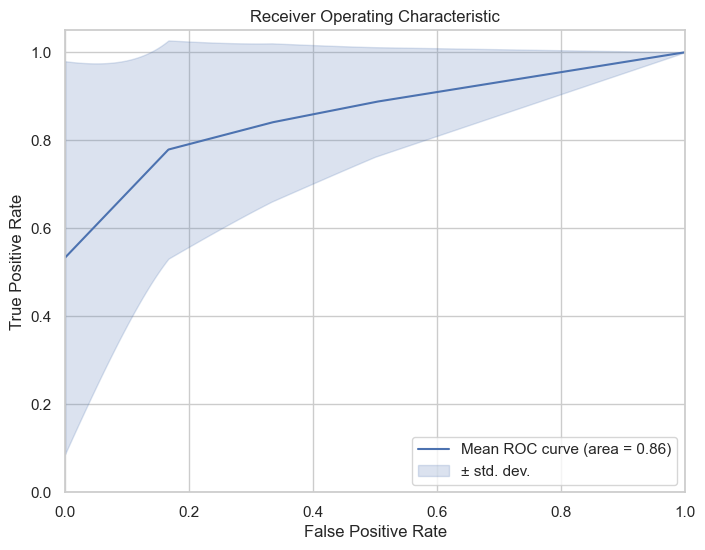

In [32]:
mean_mean_fpr = np.mean(all_mean_fprs, axis=0)
mean_mean_tpr = np.mean(all_mean_tprs, axis=0)
mean_std_tpr = np.mean(all_std_tprs, axis=0)
mean_auc = np.mean(all_aucs)

plot_avg_roc_curve(mean_mean_fpr, mean_mean_tpr, mean_std_tpr, mean_auc)

In [33]:
dataset = GraphDataset(graphs, targets)
dataset_loader = DataLoader(dataset, batch_size=3, shuffle=False)
y, preds = cnn.predict(dataset_loader)
print(y)
print(preds)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [14]:
cnn = CNNClassifier(learning_rate=8.87E-05, batch_size=4, gamma=0.975414, weight_decay=0.0)
cnn.classify(graphs, targets, verbose=True, multilayer=True)

Epoch [1]:	Training loss: 0.7334	Training Accuracy: 0.4444	Validation loss: 0.6997	Validation accuracy: 0.4167
Epoch [2]:	Training loss: 0.6925	Training Accuracy: 0.4722	Validation loss: 0.6990	Validation accuracy: 0.4167
Epoch [3]:	Training loss: 0.6885	Training Accuracy: 0.4722	Validation loss: 0.6931	Validation accuracy: 0.4167
Epoch [4]:	Training loss: 0.6836	Training Accuracy: 0.7222	Validation loss: 0.6878	Validation accuracy: 0.5833
Epoch [5]:	Training loss: 0.6819	Training Accuracy: 0.5278	Validation loss: 0.6860	Validation accuracy: 0.5833
Epoch [6]:	Training loss: 0.6758	Training Accuracy: 0.5833	Validation loss: 0.6866	Validation accuracy: 0.5833
Epoch [7]:	Training loss: 0.6766	Training Accuracy: 0.5278	Validation loss: 0.6845	Validation accuracy: 0.5833
Epoch [8]:	Training loss: 0.6706	Training Accuracy: 0.7778	Validation loss: 0.6894	Validation accuracy: 0.5833
Epoch [9]:	Training loss: 0.6626	Training Accuracy: 0.7500	Validation loss: 0.6863	Validation accuracy: 0.5833
E

(array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]),
 array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]))

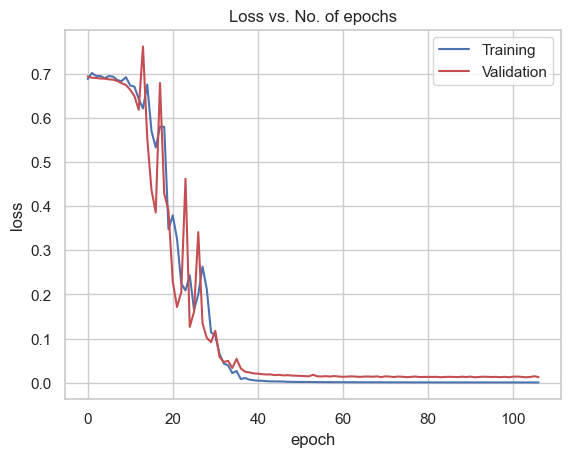

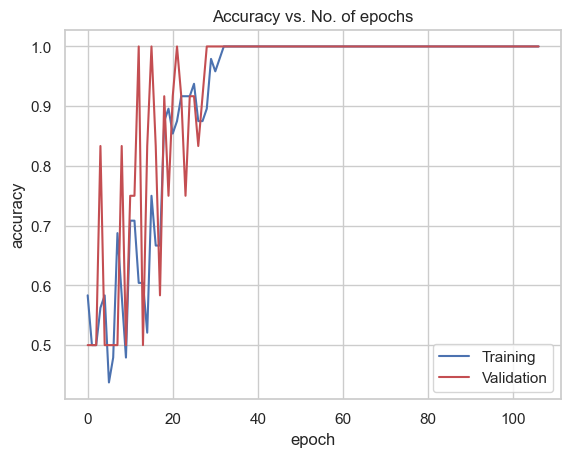

In [34]:
cnn = CNNClassifier(learning_rate=0.00019233, batch_size=4, gamma=0.840144, weight_decay=0.0001)
plot_losses(hist)
plot_accuracies(hist)

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK
wd = hp.choice("weight_decay", [0, 0.001, 0.0001, 0.00001])
print(wd)